In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

In [2]:



###########################################
#METHOD 1: Read files using file name from the csv and add corresponding 
#image in a pandas dataframe along with labels. 
#This requires lot of memory to hold all thousands of images. 
#Use datagen if you run into memory issues. 

skin_df = pd.read_csv('PROJECT/DATA-HAM-/HAM10000_metadata.csv')



In [3]:
skin_df.head()  # Default is 5 rows


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
#Adding Images

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


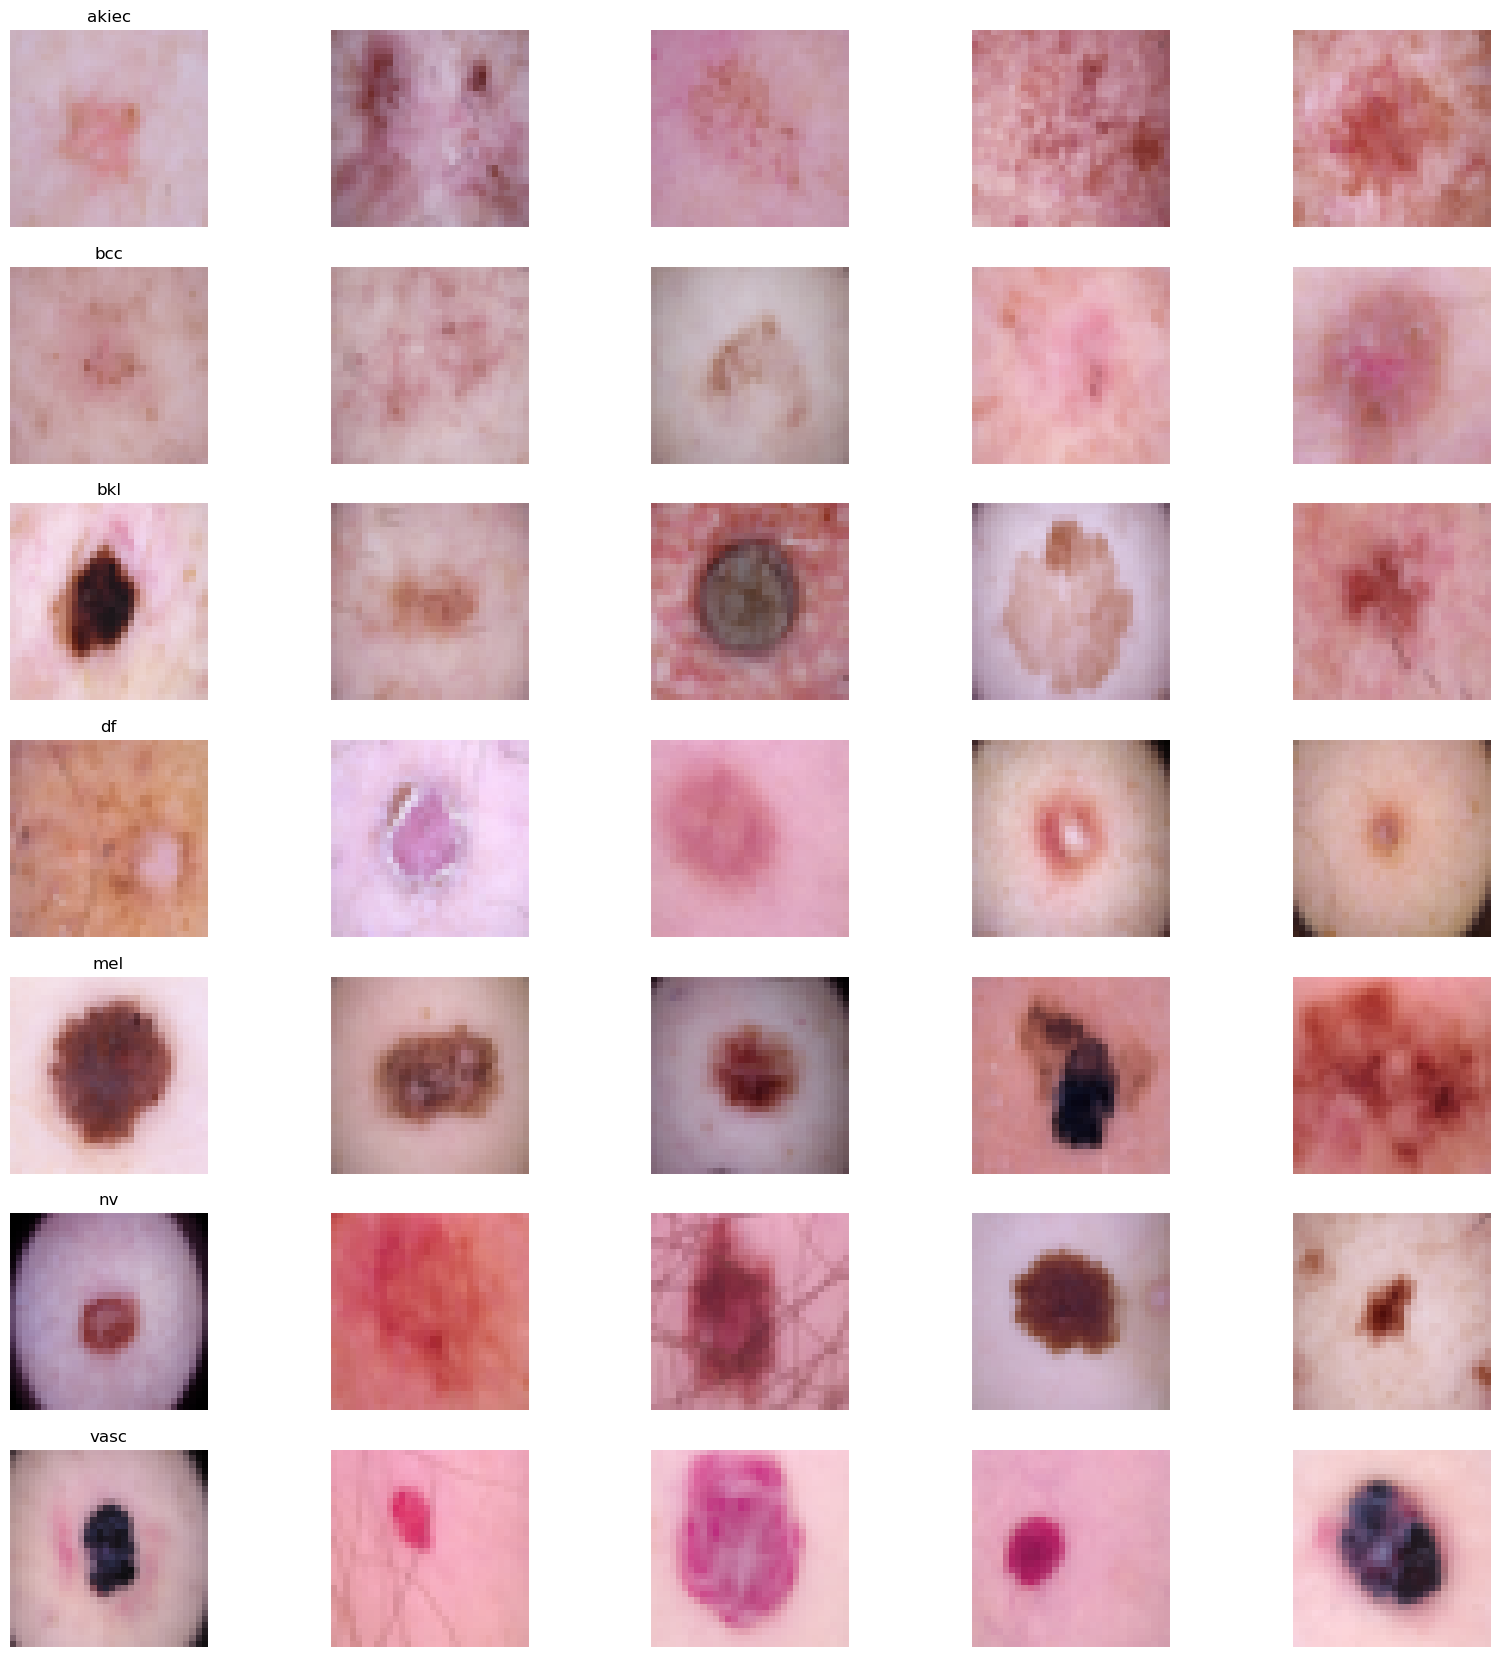

In [4]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('PROJECT/DATA-HAM-/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(skin_df['dx'].value_counts())

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#############################################################################
# Reorganize data into subfolders based on their labels
#then use keras flow_from_dir or pytorch ImageFolder to read images with 
#folder names as labels

#Sort images to subfolders first 


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

# Create a dictionary mapping image ID to file path
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('PROJECT/DATA-HAM-/', '*', '*.jpg'))}

# Add the file path as a new column in DataFrame
skin_df['path'] = skin_df['image_id'].map(image_path.get)

# Load images and resize them with high-quality interpolation
def load_image(path):
    if path and os.path.exists(path):
        return np.asarray(Image.open(path).resize((128, 128), Image.LANCZOS))
    return None  # Handle missing images

skin_df['image'] = skin_df['path'].map(load_image)

# Check label distribution
print(skin_df['dx'].value_counts())


KeyboardInterrupt: 

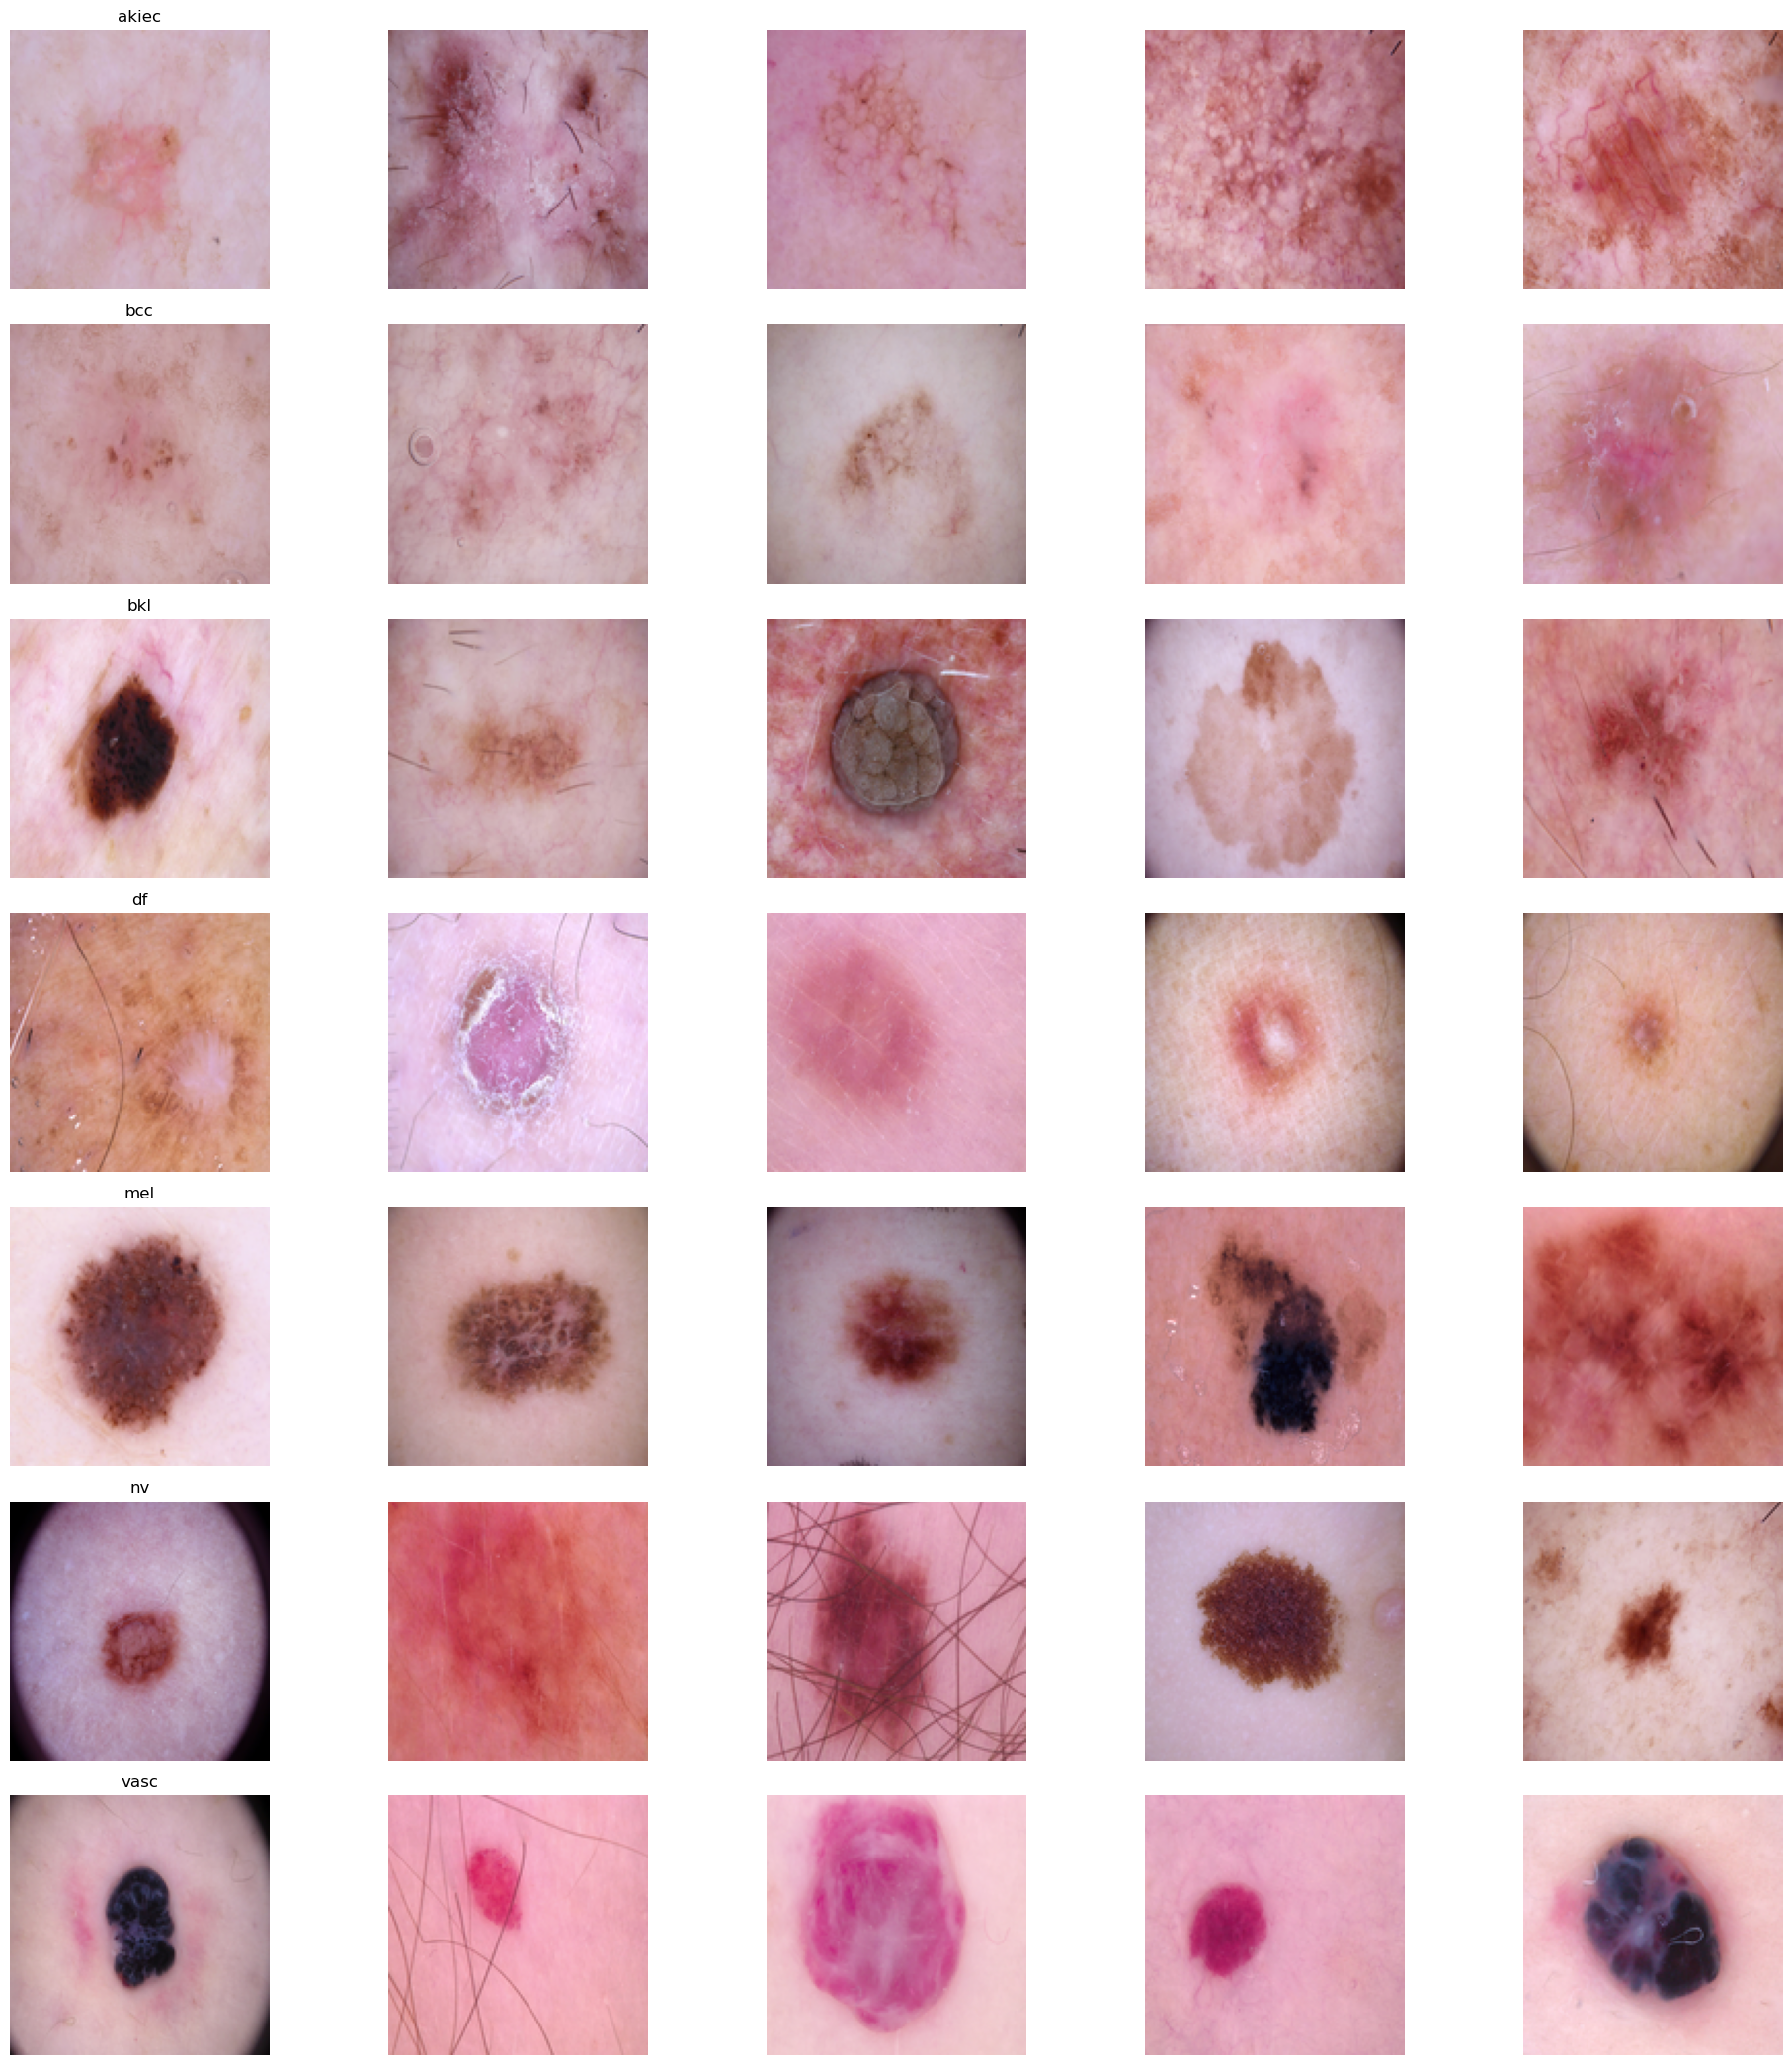

In [8]:
# Set number of samples per category
n_samples = 5

# Define the number of unique categories
unique_labels = skin_df['dx'].nunique()

# Create subplots for visualization
fig, m_axs = plt.subplots(unique_labels, n_samples, figsize=(4*n_samples, 3*unique_labels))

# Loop through each label and plot sample images
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name, fontsize=12)  # Set category title
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')  # Hide axis

# Save the figure
plt.tight_layout()
plt.savefig('category_samples.png', dpi=500)
plt.show()


In [10]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
image            0
dtype: int64

In [13]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [16]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
image           0
dtype: int64

## DATA ANALYSIS

In [19]:
print(skin_df.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'image'],
      dtype='object')


In [20]:
# Define a mapping for 'dx' to meaningful cell type names
cell_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

# Create the 'cell_type' column by mapping 'dx' values
skin_df['cell_type'] = skin_df['dx'].map(cell_type_dict)

# Check if the column is created successfully
print(skin_df[['dx', 'cell_type']].head())


    dx                      cell_type
0  bkl  Benign keratosis-like lesions
1  bkl  Benign keratosis-like lesions
2  bkl  Benign keratosis-like lesions
3  bkl  Benign keratosis-like lesions
4  bkl  Benign keratosis-like lesions


<Axes: xlabel='cell_type'>

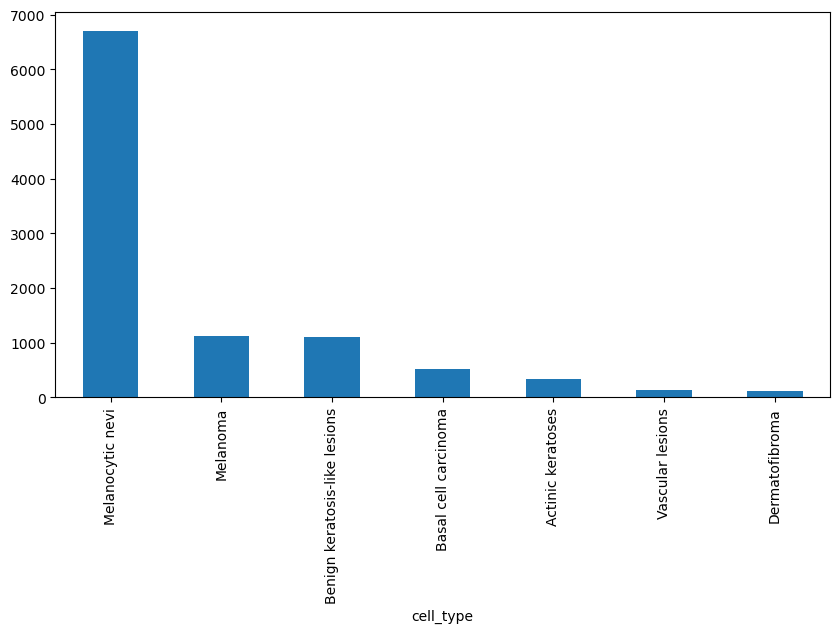

In [21]:
# Distribution of 7 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

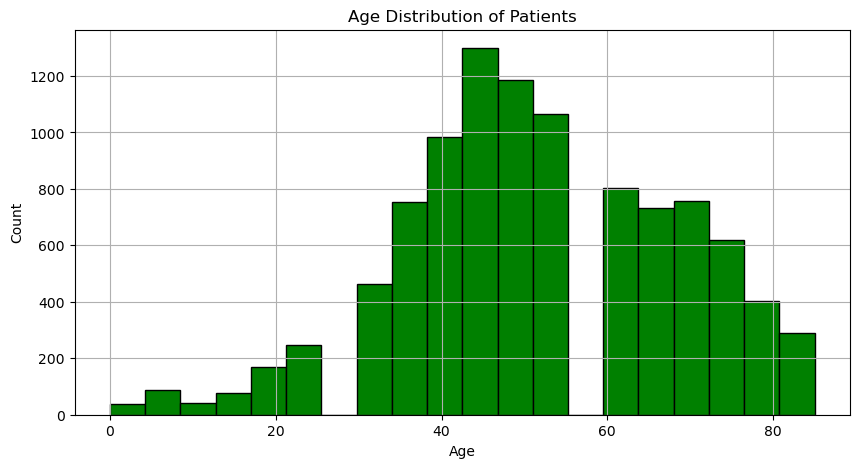

<Figure size 1200x600 with 0 Axes>

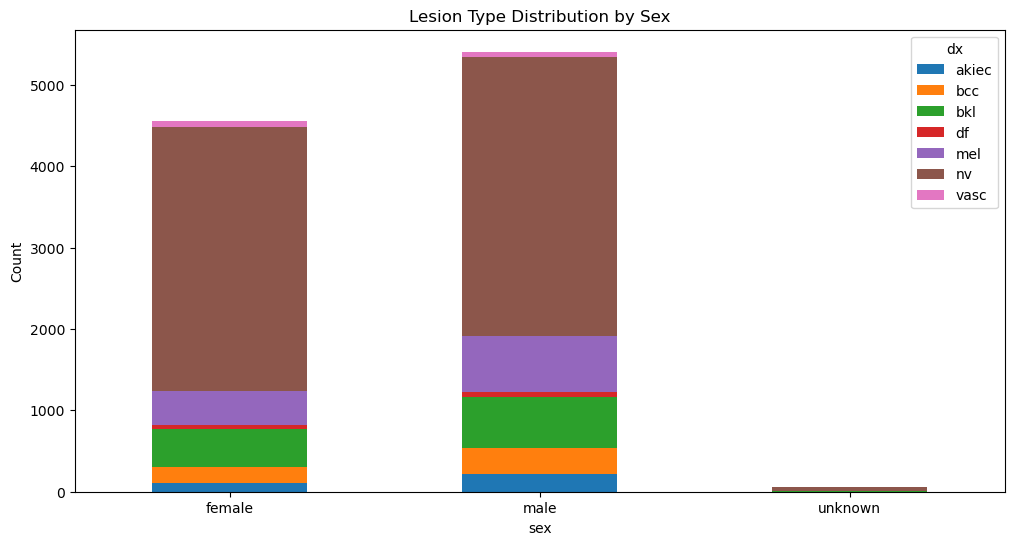

<Figure size 1200x600 with 0 Axes>

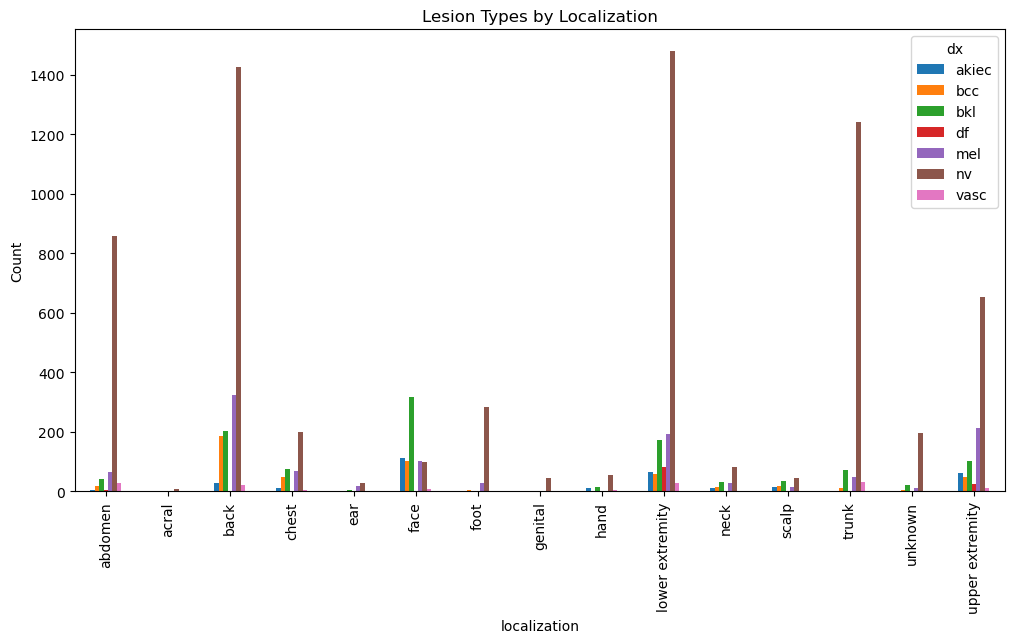

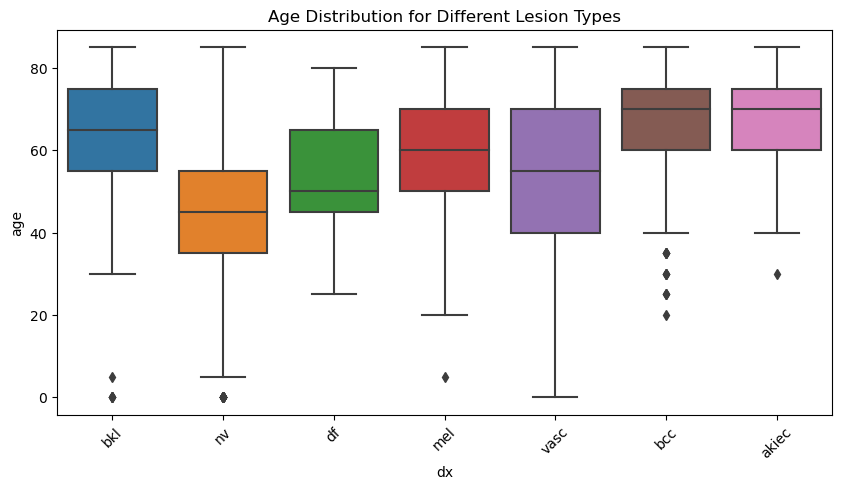

In [23]:
#CODE FOR VISULIZATION
import seaborn as sns
# 🔹 4️⃣ Age Distribution
plt.figure(figsize=(10, 5))
skin_df['age'].hist(bins=20, color='green', edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Patients")
plt.show()

# 🔹 5️⃣ Lesion Type by Sex
plt.figure(figsize=(12, 6))
skin_df.groupby('sex')['dx'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(12, 6))
plt.ylabel("Count")
plt.title("Lesion Type Distribution by Sex")
plt.xticks(rotation=0)
plt.show()

# 🔹 6️⃣ Lesion Type by Localization
plt.figure(figsize=(12, 6))
skin_df.groupby('localization')['dx'].value_counts().unstack().plot(kind='bar', figsize=(12, 6))
plt.ylabel("Count")
plt.title("Lesion Types by Localization")
plt.xticks(rotation=90)
plt.show()

# 🔹 7️⃣ Correlation Between Age and Lesion Type
plt.figure(figsize=(10, 5))
sns.boxplot(x='dx', y='age', data=skin_df)
plt.xticks(rotation=45)
plt.title("Age Distribution for Different Lesion Types")
plt.show()

In [24]:
# this will tell us how many images are associated with each lesion_id
df_ = skin_df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_ = df_[df_['image_id'] == 1]

df_.reset_index(inplace=True)

df_.head()

lesion_id  image_id  dx  dx_type  age  sex  localization  path  image  \
0  HAM_0000001         1   1        1    1    1             1     1      1   
1  HAM_0000003         1   1        1    1    1             1     1      1   
2  HAM_0000004         1   1        1    1    1             1     1      1   
3  HAM_0000007         1   1        1    1    1             1     1      1   
4  HAM_0000008         1   1        1    1    1             1     1      1   

   cell_type  
0          1  
1          1  
2          1  
3          1  
4          1

In [25]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
skin_df['duplicates'] = skin_df['lesion_id']
# apply the function to this new column
skin_df['duplicates'] = skin_df['duplicates'].apply(identify_duplicates)

skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
1  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
2  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
3  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
4  PROJECT/DATA-HAM-\HAM10000_images_part_2\ISIC_...   

                                               image  \
0  [[[189, 153, 194], [193, 156, 199], [191, 155,...   
1  [[[24, 13, 22], [24, 14, 22], [25, 14, 26], [2...   
2  [[[187, 127, 136], [190, 134, 146], [194, 136,...   
3  [[[24, 11, 17], [24, 11, 19], [28, 15, 25], [3...   
4  [[[129, 87, 109], [141, 96, 119], [151, 106, 1...   

                       cell_type      duplicates  
0  Benign keratosis-like lesions  has_duplicates  
1  Benign keratosis-like lesions  has_duplicates  
2  Benign keratosis-like lesions  has_duplicates  
3  Benign keratosis-like lesions  has_duplicates  
4  Benign keratosis-like lesions  has_duplicates

In [29]:
skin_df['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [30]:
# skin_df['duplicates'].value_counts()
# now we filter out images that don't have duplicates
df_ = skin_df[skin_df['duplicates'] == 'no_duplicates']

df_.shape

(5514, 11)

In [39]:
! pip install tensorflow
from tensorflow.keras.utils import to_categorical


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from tensorflow.keras.utils import to_categorical
 # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Different One

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization                                               path  \
1617             face  PROJECT/DATA-HAM-\HAM10000_images_part_2\ISIC_...   
8128  lower extremity  PROJECT/DATA-HAM-\HAM10000_images_part_2\ISIC_...   
2168 

C:\Users\DeLL\AppData\Local\Temp\ipykernel_23492\1489307912.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


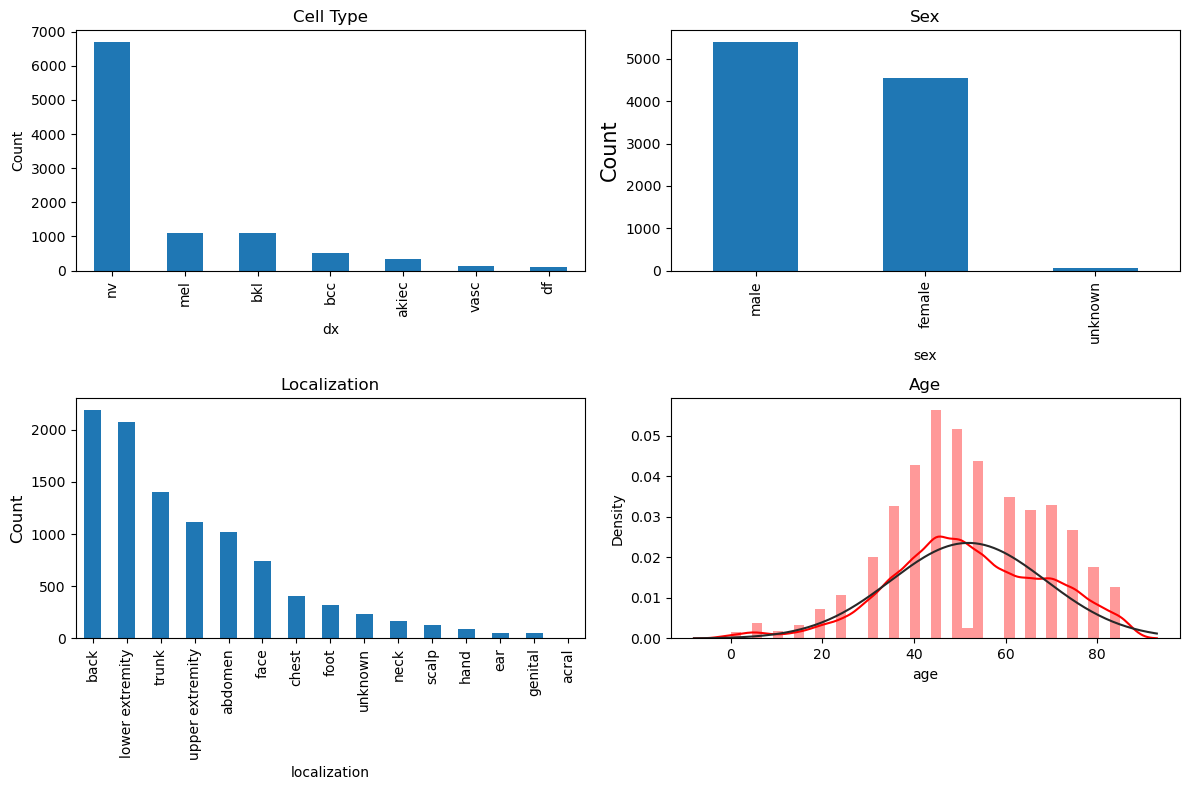

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [42]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

In [44]:
SIZE=32
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

C:\Users\DeLL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (None, 12544)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
4236  HAM_0006349  ISIC_0024919   nv  follow_up  50.0  female   
5405  HAM_0000944  ISIC_0027864   nv  follow_up  75.0    male   
4034  HAM_0005042  ISIC_0026220   nv  follow_up  60.0  female   
7870  HAM_0006182  ISIC_0033789   nv      histo  35.0    male   
595   HAM_0002357  ISIC_0031783  bkl      histo  70.0    male   
6921  HAM_0003627  ISIC_0026497   nv      histo  30.0  female   
2034  HAM_0004171  ISIC_0024644  mel      histo  85.0  female   
2231  HAM_0005789  ISIC_0032204  mel      histo  55.0    male   
8370  HAM_0003113  ISIC_0024520   nv      histo  60.0    male   
4497  HAM_0000981  ISIC_0024311   nv  follow_up  75.0  female   

         localization                                               path  \
4236            trunk  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
5405  upper extremity  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
4034 

C:\Users\DeLL\AppData\Local\Temp\ipykernel_23492\463747762.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


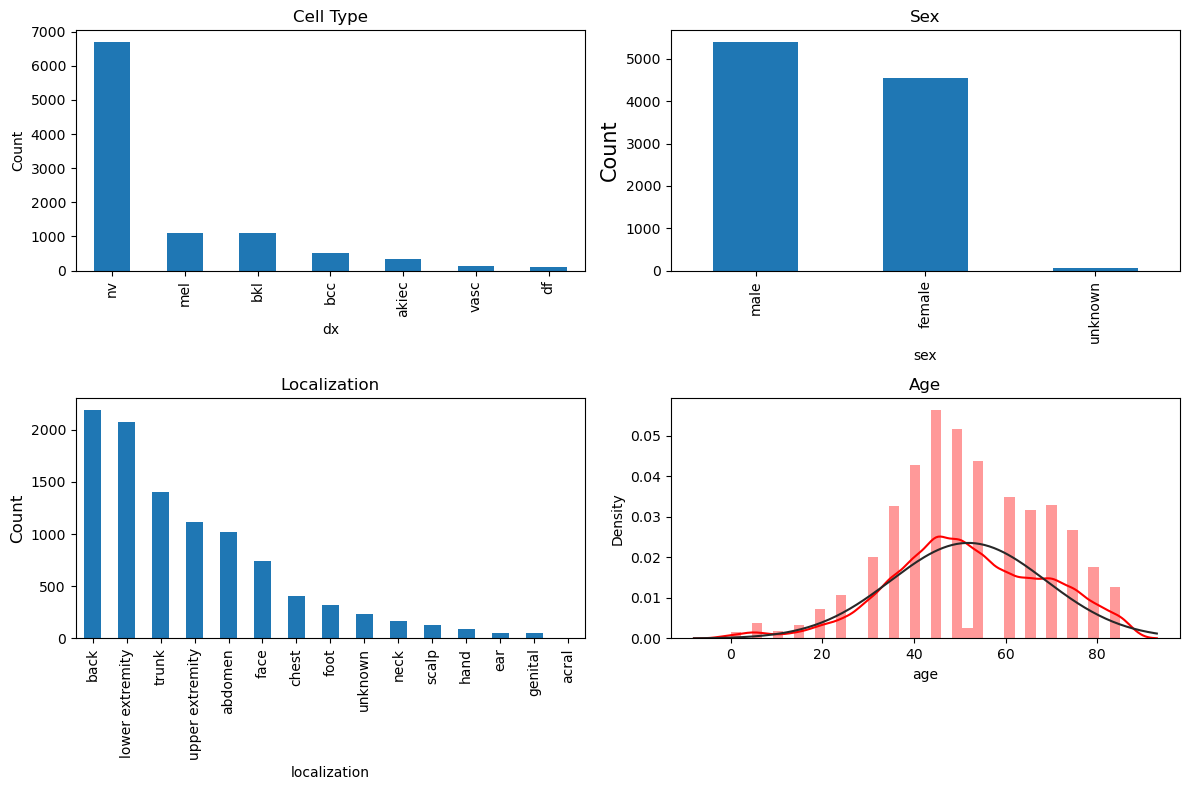

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


C:\Users\DeLL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 - 30s - 181ms/step - acc: 0.1916 - loss: 1.8944 - val_acc: 0.2491 - val_loss: 1.8588
Epoch 2/50
165/165 - 20s - 124ms/step - acc: 0.3166 - loss: 1.6515 - val_acc: 0.3749 - val_loss: 1.5127
Epoch 3/50
165/165 - 23s - 142ms/step - acc: 0.3920 - loss: 1.4979 - val_acc: 0.3920 - val_loss: 1.4627
Epoch 4/50
165/165 - 49s - 295ms/step - acc: 0.4362 - loss: 1.4285 - val_acc: 0.4149 - val_loss: 1.4018
Epoch 5/50
165/165 - 19s - 114ms/step - acc: 0.4530 - loss: 1.3772 - val_acc: 0.3943 - val_loss: 1.5691
Epoch 6/50
165/165 - 20s - 122ms/step - acc: 0.4537 - loss: 1.3850 - val_acc: 0.4640 - val_loss: 1.3162
Epoch 7/50
165/165 - 20s - 119ms/step - acc: 0.4872 - loss: 1.2929 - val_acc: 0.4914 - val_loss: 1.2867
Epoch 8/50
165/165 - 19s - 114ms/step - acc: 0.4884 - loss: 1.2794 - val_acc: 0.5086 - val_loss: 1.2865
Epoch 9/50
165/165 - 17s - 106ms/step - acc: 0.5150 - loss: 1.2346 - val_acc: 0.4994 - val_loss: 1.2849
Epoch 10/50
165/165 - 20s - 121ms/step - acc: 0.5406 - loss: 1.2

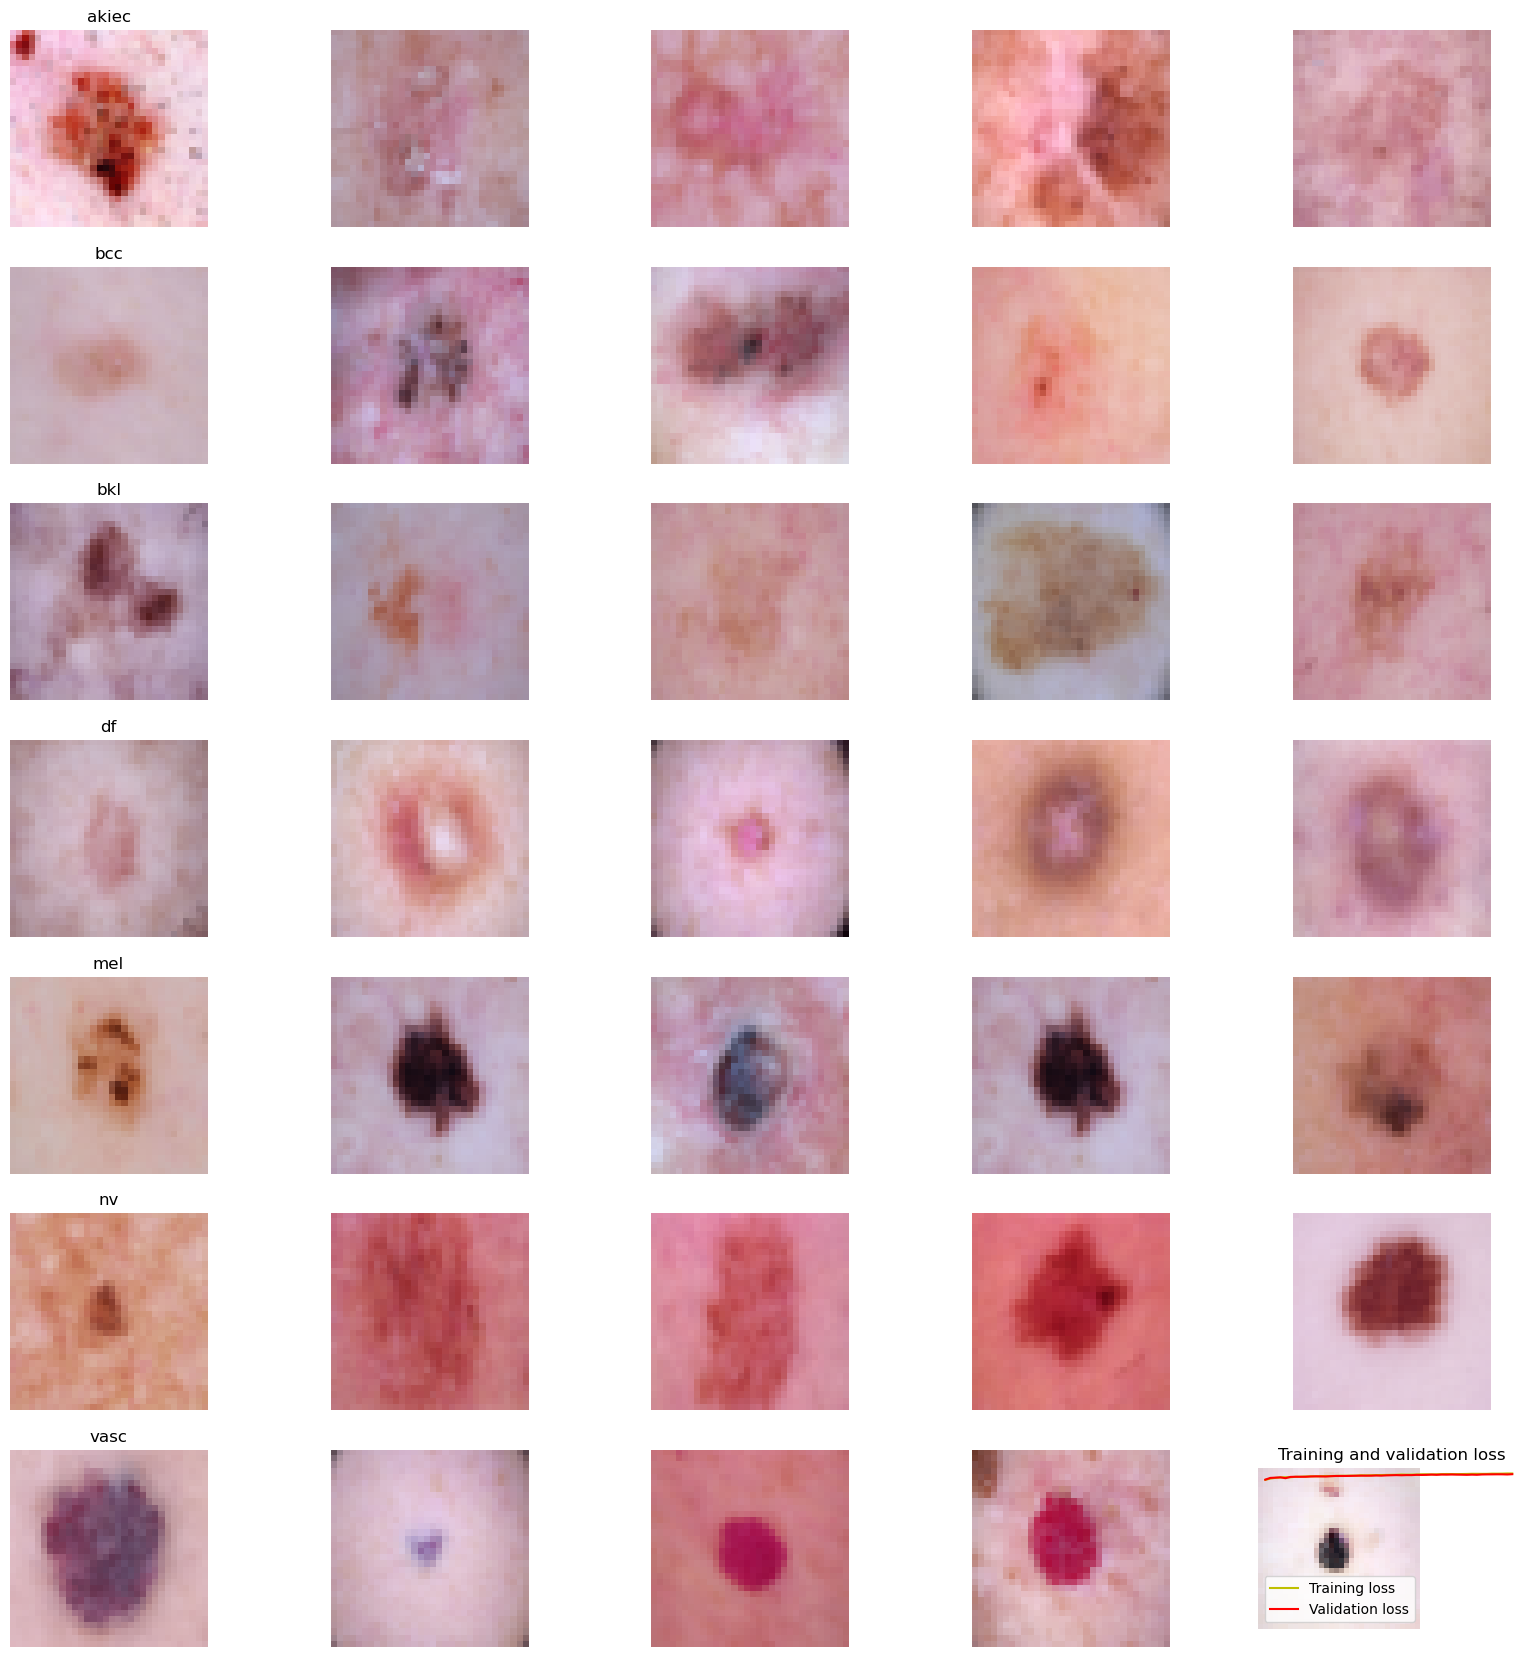

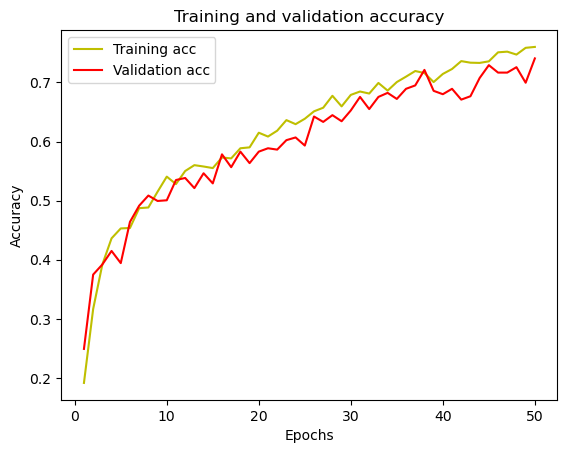

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Text(47.722222222222214, 0.5, 'Fraction of incorrect predictions')

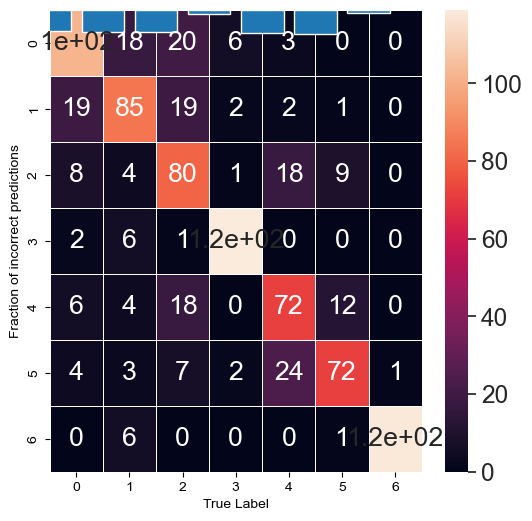

In [48]:
# skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('PROJECT/DATA-HAM-/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [49]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
1  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
2  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
3  PROJECT/DATA-HAM-\HAM10000_images_part_1\ISIC_...   
4  PROJECT/DATA-HAM-\HAM10000_images_part_2\ISIC_...   

                                               image  \
0  [[[189, 153, 194], [193, 156, 199], [191, 155,...   
1  [[[24, 13, 22], [24, 14, 22], [25, 14, 26], [2...   
2  [[[187, 127, 136], [190, 134, 146], [194, 136,...   
3  [[[24, 11, 17], [24, 11, 19], [28, 15, 25], [3...   
4  [[[129, 87, 109], [141, 96, 119], [151, 106, 1...   

                       cell_type      duplicates  label  
0  Benign keratosis-like lesions  has_duplicates      2  
1  Benign keratosis-like lesions  has_duplicates      2  
2  Benign keratosis-like lesions  has_duplicates      2  
3  Benign keratosis-like lesions  has_duplicates      2  
4  Benign keratosis-like lesions  has_duplicates      2

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


C:\Users\DeLL\AppData\Local\Temp\ipykernel_23492\2977723195.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50


C:\Users\DeLL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 - 19s - 115ms/step - accuracy: 0.1493 - loss: 1.9511 - val_accuracy: 0.1589 - val_loss: 1.9492
Epoch 2/50
165/165 - 6s - 39ms/step - accuracy: 0.1451 - loss: 1.9494 - val_accuracy: 0.1463 - val_loss: 1.9494
Epoch 3/50
165/165 - 7s - 45ms/step - accuracy: 0.1356 - loss: 1.9547 - val_accuracy: 0.1611 - val_loss: 1.9451
Epoch 4/50
165/165 - 10s - 59ms/step - accuracy: 0.1440 - loss: 1.9510 - val_accuracy: 0.1520 - val_loss: 1.9455
Epoch 5/50
165/165 - 8s - 48ms/step - accuracy: 0.1459 - loss: 1.9483 - val_accuracy: 0.1726 - val_loss: 1.9415
Epoch 6/50
165/165 - 8s - 46ms/step - accuracy: 0.1402 - loss: 1.9511 - val_accuracy: 0.1989 - val_loss: 1.9394
Epoch 7/50
165/165 - 7s - 44ms/step - accuracy: 0.1432 - loss: 1.9505 - val_accuracy: 0.1851 - val_loss: 1.9385
Epoch 8/50
165/165 - 8s - 47ms/step - accuracy: 0.1451 - loss: 1.9507 - val_accuracy: 0.1577 - val_loss: 1.9395
Epoch 9/50
165/165 - 8s - 48ms/step - accuracy: 0.1360 - loss: 1.9536 - val_accuracy: 0.1840 - val_loss: 1.9375


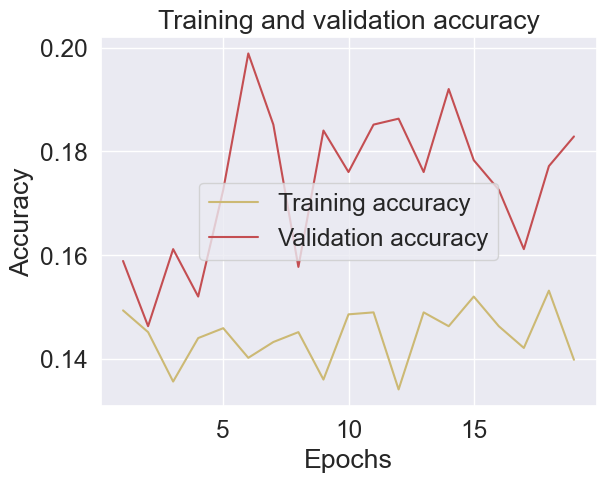

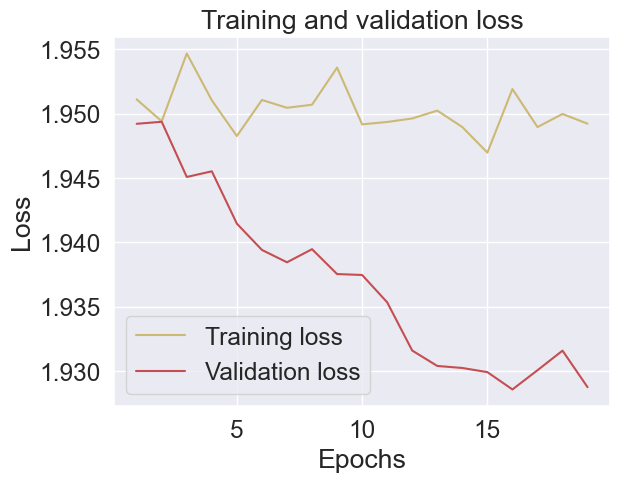

In [52]:
#Mobile NET
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Load MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base model (so that it doesn't get updated during training)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Summary of the model
model.summary()

# Data augmentation for training images
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Training the model
batch_size = 16
epochs = 50

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate model on test data
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

# Plotting training and validation accuracy/loss
import matplotlib.pyplot as plt

# Accuracy plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [53]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Load DenseNet121 as base model
base_model_densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base model
base_model_densenet121.trainable = False

# Add custom top layers
x = base_model_densenet121.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Construct the final model
model_densenet121 = Model(inputs=base_model_densenet121.input, outputs=predictions)

# Compile the model
model_densenet121.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Summary of the model
model_densenet121.summary()

# Data augmentation for training images
datagen_densenet121 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Training the model
history_densenet121 = model_densenet121.fit(
    datagen_densenet121.flow(x_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate model on test data
score_densenet121 = model_densenet121.evaluate(x_test, y_test)
print('Test accuracy (DenseNet121):', score_densenet121[1])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 38, 38, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 8, 8, 64)  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 64)  │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_0_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 128) │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 128) │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 128) │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 32)  │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 8, 8, 96)  │          0 │ pool1[0][0],      │
│ (Concatenate)       │                   │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 8, 8, 96)  │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 8, 8, 96)  │          0 │ conv2_block2_0_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 8, 8, 128) │     12,288 │ conv2_block2_0_r

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
165/165 - 37s - 227ms/step - accuracy: 0.1223 - loss: 2.7551 - val_accuracy: 0.1337 - val_loss: 2.2201
Epoch 2/50
165/165 - 14s - 86ms/step - accuracy: 0.1490 - loss: 2.4272 - val_accuracy: 0.1029 - val_loss: 2.1544
Epoch 3/50
165/165 - 15s - 91ms/step - accuracy: 0.1486 - loss: 2.3147 - val_accuracy: 0.1234 - val_loss: 2.1405
Epoch 4/50
165/165 - 16s - 95ms/step - accuracy: 0.1470 - loss: 2.2356 - val_accuracy: 0.1086 - val_loss: 2.0968
Epoch 5/50
165/165 - 17s - 101ms/step - accuracy: 0.1516 - loss: 2.1563 - val_accuracy: 0.1269 - val_loss: 2.0877
Epoch 6/50
165/165 - 16s - 98ms/step - accuracy: 0.1410 - loss: 2.1244 - val_accuracy: 0.1383 - val_loss: 2.0602
Epoch 7/50
165/165 - 14s - 85ms/step - accuracy: 0.1512 - loss: 2.0800 - val_accuracy: 0.1691 - val_loss: 2.0613
Epoch 8/50
165/165 - 14s - 85ms/step - accuracy: 0.1543 - loss: 2.0624 - val_accuracy: 0.1429 - val_loss: 2.0346
Epoch 9/50
165/165 - 15s - 90ms/step - accuracy: 0.1497 - loss: 2.0431 - val_accuracy: 0.1383 